In [1]:
# add h4d proj root to sys.path so we can import stuff that's in h4d_main/h4d:
# Example: suppose you want to import something from <h4d_main>/h4d/h4d/submodule/:
# "import h4d.submodule" or "from h4d.submodule import foo"
import sys, subprocess
sys.path.append(subprocess.check_output(['git','rev-parse','--show-toplevel']).strip().decode("utf-8") )

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from collections import Counter, namedtuple
from pycocotools.coco import COCO
import json
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os.path
import pylab
import numpy as np

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from h4dlib.data.cocohelpers import *
from h4dlib.config import h4dconfig

pylab.rcParams['figure.figsize'] = (8.0, 10.0)

from h4dlib.data.cocohelpers import split2

import string
import random
import math

def randomString(stringLength=10):
    """Generate a random string of fixed length """
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

prefixes = [randomString() for i in range(10)]
source_map = {}
for prefix in prefixes:
    source_map[prefix] = [prefix + '-' + str(math.floor(random.random()*100)) + '.jpeg' for i in range(10)]

sources = sorted(source_map.keys())
for source in sources:
    images = sorted(source_map[source])
    source_map[source] = images

train_names, val_names = split2(
    source_map, sources, test_size=0.2, random_state=5, sample_rate=0.5
)


In [3]:
def default(obj):
    """Used to serilize numpy arrays to json"""
    if type(obj).__module__ == np.__name__:
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return obj.item()
    raise TypeError('Unknown type:', type(obj))

def plot_class_dist(cat_counts, title_suffix="", sort=True, log_only=False):
    """
    params:
        dataset:string: name of the coco dataset to use, values 
        something like 'train2014' or 'val2014'
    """
    cat_names = np.array(list(cat_counts.keys()))
    cat_freqs = np.array(list(cat_counts.values()))
    idx = np.argsort(-cat_freqs) if sort else np.argsort(cat_names)
    fig_size, dpi, rotation = (14, 6), 80, 90
    # Raw
    if not log_only:
        plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor='w', edgecolor='k')
        plt.bar(cat_names[idx], cat_freqs[idx])
        plt.xticks(rotation=rotation)
        plt.title("Class Distribution (Raw) " + title_suffix)
        plt.show()
    # Log
    plt.figure(num=None, figsize=fig_size, dpi=dpi, facecolor='w', edgecolor='k')
    plt.bar(cat_names[idx], np.log10(cat_freqs[idx]))
    plt.xticks(rotation=rotation)
    plt.title("Class Distribution (log_10) " + title_suffix)
    plt.show()
    print(list(zip(cat_names[idx], cat_freqs[idx])))

### What's the class distribution? 

In [4]:
coco = CocoClassDistHelper("../../data/Xview/coco_chipped/xview_coco_v2_train_chipped.json")

loading annotations into memory...
Done (t=2.37s)
creating index...
index created!
num images: 19631
num annotations: 418217


In [8]:
# print(type(coco.anns), coco.anns['0'])
# print(coco.anns[list(coco.anns.keys())[0]])
# cat_counts, cat_percents = coco.get_class_dist()
# plot_class_dist(cat_counts, sort=False)
print(coco.imgs[1])
print(coco.imgToAnns[1])

{'license': 1, 'file_name': 'COCO_train_000000000001.jpg', 'coco_url': '', 'width': 512, 'height': 512, 'date_captured': '2018-02-22 00:00:00', 'flickr_url': '', 'id': 1}
[{'bbox': [507, 318, 5, 33], 'segmentation': [[507.0, 318.0, 507.0, 351.0, 512.0, 351.0, 512.0, 318.0]], 'area': 165, 'iscrowd': 0, 'image_id': 1, 'category_id': 8, 'id': '0'}]


In [10]:
print(cat_percents)

[3.22048570e-04 3.05008963e-04 1.17965198e-02 3.60007702e-01
 2.98193120e-04 4.99260481e-04 2.96489159e-04 1.81131021e-03
 2.86776583e-03 1.42791906e-03 1.50459729e-03 1.15869327e-04
 2.06179243e-04 1.20640417e-03 1.20299624e-03 2.07883204e-04
 3.67714716e-03 1.26093091e-04 5.32361621e-01 1.64943394e-03
 3.99749177e-03 5.03179591e-03 3.57150160e-03 3.87327304e-02
 2.71611333e-03 1.13824574e-03 6.20241690e-04 2.01919341e-03
 6.16833768e-04 2.82857474e-03 1.05645563e-04 2.57298064e-04
 1.44836658e-04 2.52186182e-04 1.60768691e-02]


### Search for the best Split:
<span style="color:red">_Warning!_</span> This cell takes around an hour to run with seed_end=10,000

The quality or score for a split is determined by the l2 distance between a vector representing the class balances of the train and val portions of the split. The vector elements are percentages, not absolute counts. For example if the classes are "A", "B", "C", then a vector for the train split might look like [0.10, 0.30, 0.60]. 

The chunk below tries 1000 random train/val splits and picks the one with the lowest l2 distance between train and val.

In [67]:
seed_start = 200000
seed_end   = 400000
test_size = 0.3
results_file = "./split_search_v5.json"

def save_results(results, results_file):
    dumped = json.dumps(results, default=default)
    with open(results_file, 'w') as split_search_file:
        split_search_file.write(dumped)

In [68]:
# Generating splits is slow, so save all the info as we go, so we can analyze in a separate step.
# Analysis part (later) is much faster this way because we can play with different objective functions
# more quickly.
def split_search():
    results = {}
    cat_names = list(sorted([c["name"] for c in coco.cats]))
    for seed in tqdm(range(seed_start,seed_end), mininterval=0.5):
        train_img_ids, val_img_ids = split(coco.img_ids, test_size=test_size, random_state=seed)
        train_counts, train_percents = coco.get_class_dist(train_img_ids)
        val_counts, val_percents = coco.get_class_dist(val_img_ids)
        
        # Make np array of min class counts (across both splits):
        min_counts = np.zeros((len(coco.cats,)), np.int)
        for idx, cat_name in enumerate(cat_names):
            min_counts[idx] = min(
                val_counts[cat_name] if cat_name in val_counts else 0
                , train_counts[cat_name] if cat_name in train_counts else 0)
        
        min_cat_count = np.min(min_counts)
#         l2 = (
#             np.linalg.norm(train_percents-cat_percents) 
#             + np.linalg.norm(val_percents-cat_percents)
#         )
        linf = np.linalg.norm(np.abs(train_percents-val_percents), ord=np.inf)
        if (
            min_cat_count > 2
#             and l2 <= 0.0055
            and linf <= 0.0036
        ):
            results[seed] = {
                "train_img_ids": train_img_ids
                , "val_img_ids": val_img_ids
                , "train_counts": train_counts
                , "train_percents": train_percents
                , "val_counts": val_counts
                , "val_percents": val_percents
                , "min_cat_count": min_cat_count
                , "seed": seed
            }
        if seed % 10000 == 0:
            save_results(results, results_file)
    save_results(results, results_file)
split_search()

100%|██████████| 200000/200000 [29:30<00:00, 112.97it/s]


The above cell saves the split search results into a json file, since it can take a long time to run the search. This cell loads the results into a list:

In [69]:
def load_results():
    """
    Load split search results from split_search.json, into a list of dictionaries.
    """
    json_str = open(results_file, 'r', encoding='utf-8').read()
    raw_dict = json.loads(json_str)
    results = []
    def tointlist(ls):
        return [int(x) for x in ls]
    for seed in tointlist(raw_dict.keys()):
        raw = raw_dict[str(seed)]
        results.append({
            "seed": seed
#             , "train_img_ids": raw["train_img_ids"]
#             , "val_img_ids": raw["val_img_ids"]
            , "train_counts": raw["train_counts"]
            , "train_percents": np.array(raw["train_percents"])
            , "val_counts": raw["val_counts"]
            , "val_percents": np.array(raw["val_percents"])
            , "min_cat_count": raw["min_cat_count"]
        })
    return results

results = load_results()
print(F"Loaded {len(results)} split search results from {results_file}")

Loaded 1332 split search results from ./split_search_v5.json


This next cell lets you define a custom scoring function. The score is a way to rate how good a particular split is. Lower score = better. The results from the split search are sorted by this scoring function and we display the top 20.

The one I've been using uses the infinity norm, i.e., max element of the absolute value of x, where x is the vector of differences from the train or val split from the original data. For example if there are three classes, we'd have a vector of three elements, the sum of the vector's elements would equal 1, since the percentage of annotations in all the classes must sum to the total. We want to minimize the infinity norm of x, i.e., minimize highest difference in class balance between train/val and the original data.



In [72]:
eps = 0.00000001 # Use this to prevent numerical or divide by 0 issues

def score_fn(result):
    val_pct = result["val_percents"]
    train_pct = result["train_percents"]
    val_diff = val_pct - cat_percents
    train_diff = train_pct - cat_percents
    # penalize splits where a category has really low counts:
    low_count_penalty = 1 / (result["min_cat_count"]+eps)**5
    # minimize the diff in class pct btw the original data and the splits:
    return max(np.linalg.norm(val_diff, ord=np.inf) , np.linalg.norm(train_diff, ord=np.inf)) + low_count_penalty

def score_fn2(result):
    """Direct compare of train/val instead of comparing each to original data distribution"""
    val_pct = result["val_percents"]
    train_pct = result["train_percents"]
    diff = np.abs(train_pct - val_pct)
    # penalize splits where a category has really low counts:
    low_count_penalty = 20 / (result["min_cat_count"]+eps)**4
    # minimize the diff in class pct btw the original data and the splits:
    return np.linalg.norm(diff, ord=np.inf) + low_count_penalty

# sort by score:
splits = list(sorted(results, key=score_fn2, reverse=False))

# Show top 20 seeds by score (lower score is better):
print("Top 20 seeds: ", [split["seed"] for split in splits[:20]])
print("Top 20 Scores (score, l2-norm, min(class-count), class-count-penalty):")
for r in splits[:20]:
    low_count_penalty = 20 / (r["min_cat_count"]+eps)**4
    l2 = (
        np.linalg.norm(r["train_percents"]-cat_percents) 
        + np.linalg.norm(r["val_percents"]-cat_percents)
    )
    linf = np.linalg.norm(r["train_percents"]-r["val_percents"], ord=np.inf)
    print(F"{r['seed']}, scor{score_fn2(r):.6f}, linf:{linf:.5f}, l2:{l2:.6f}"
        + F", cls_cnt:{int(r['min_cat_count'])}"
        + F", cnt_pnlty:{low_count_penalty:.5f}"
     )


Top 20 seeds:  [341589, 290670, 290907, 331024, 306404, 296199, 281361, 329331, 261872, 251445, 340865, 248212, 329744, 340314, 230930, 308760, 284360, 383825, 366180, 270230]
Top 20 Scores (score, l2-norm, min(class-count), class-count-penalty):
341589, scor0.001953, linf:0.00188, l2:0.004035, cls_cnt:23, cnt_pnlty:0.00007
290670, scor0.001985, linf:0.00159, l2:0.003909, cls_cnt:15, cnt_pnlty:0.00040
290907, scor0.002173, linf:0.00187, l2:0.004074, cls_cnt:16, cnt_pnlty:0.00031
331024, scor0.002240, linf:0.00205, l2:0.005255, cls_cnt:18, cnt_pnlty:0.00019
306404, scor0.002245, linf:0.00201, l2:0.003959, cls_cnt:17, cnt_pnlty:0.00024
296199, scor0.002255, linf:0.00202, l2:0.003884, cls_cnt:17, cnt_pnlty:0.00024
281361, scor0.002279, linf:0.00204, l2:0.004043, cls_cnt:17, cnt_pnlty:0.00024
329331, scor0.002297, linf:0.00214, l2:0.004936, cls_cnt:19, cnt_pnlty:0.00015
261872, scor0.002386, linf:0.00226, l2:0.004636, cls_cnt:20, cnt_pnlty:0.00012
251445, scor0.002395, linf:0.00224, l2:0.0

### Inspect the best split from the above search:

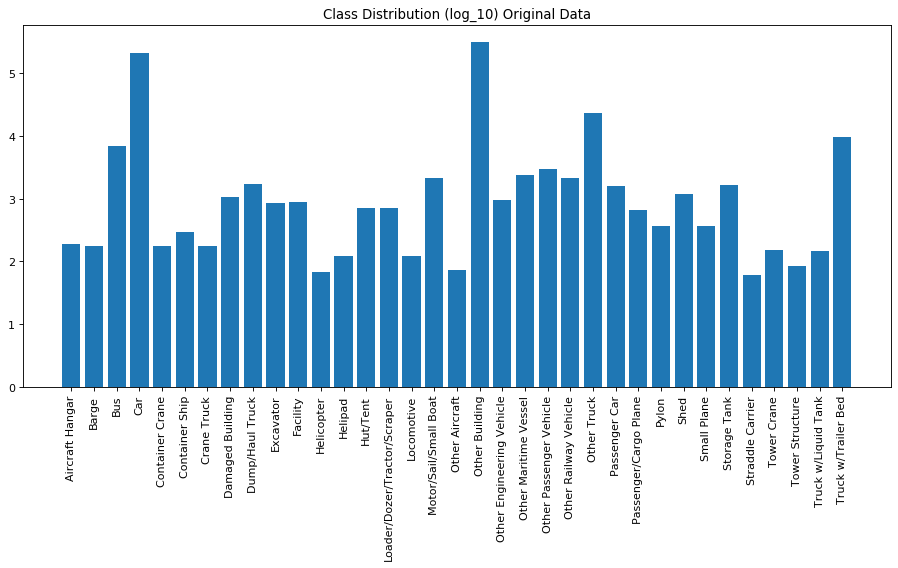

[('Aircraft Hangar', 189), ('Barge', 179), ('Bus', 6923), ('Car', 211277), ('Container Crane', 175), ('Container Ship', 293), ('Crane Truck', 174), ('Damaged Building', 1063), ('Dump/Haul Truck', 1683), ('Excavator', 838), ('Facility', 883), ('Helicopter', 68), ('Helipad', 121), ('Hut/Tent', 708), ('Loader/Dozer/Tractor/Scraper', 706), ('Locomotive', 122), ('Motor/Sail/Small Boat', 2158), ('Other Aircraft', 74), ('Other Building', 312426), ('Other Engineering Vehicle', 968), ('Other Maritime Vessel', 2346), ('Other Passenger Vehicle', 2953), ('Other Railway Vehicle', 2096), ('Other Truck', 22731), ('Passenger Car', 1594), ('Passenger/Cargo Plane', 668), ('Pylon', 364), ('Shed', 1185), ('Small Plane', 362), ('Storage Tank', 1660), ('Straddle Carrier', 62), ('Tower Crane', 151), ('Tower Structure', 85), ('Truck w/Liquid Tank', 148), ('Truck w/Trailer Bed', 9435)]


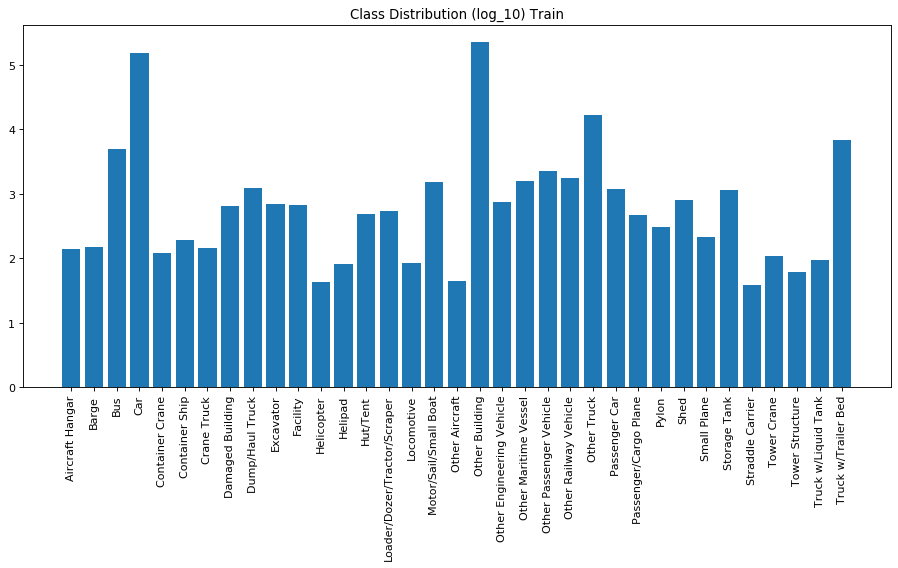

[('Aircraft Hangar', 138), ('Barge', 147), ('Bus', 4959), ('Car', 153621), ('Container Crane', 122), ('Container Ship', 192), ('Crane Truck', 145), ('Damaged Building', 654), ('Dump/Haul Truck', 1244), ('Excavator', 685), ('Facility', 658), ('Helicopter', 42), ('Helipad', 81), ('Hut/Tent', 482), ('Loader/Dozer/Tractor/Scraper', 536), ('Locomotive', 85), ('Motor/Sail/Small Boat', 1508), ('Other Aircraft', 44), ('Other Building', 226657), ('Other Engineering Vehicle', 739), ('Other Maritime Vessel', 1604), ('Other Passenger Vehicle', 2251), ('Other Railway Vehicle', 1735), ('Other Truck', 16642), ('Passenger Car', 1174), ('Passenger/Cargo Plane', 462), ('Pylon', 307), ('Shed', 809), ('Small Plane', 217), ('Storage Tank', 1158), ('Straddle Carrier', 39), ('Tower Crane', 110), ('Tower Structure', 62), ('Truck w/Liquid Tank', 95), ('Truck w/Trailer Bed', 6766)]


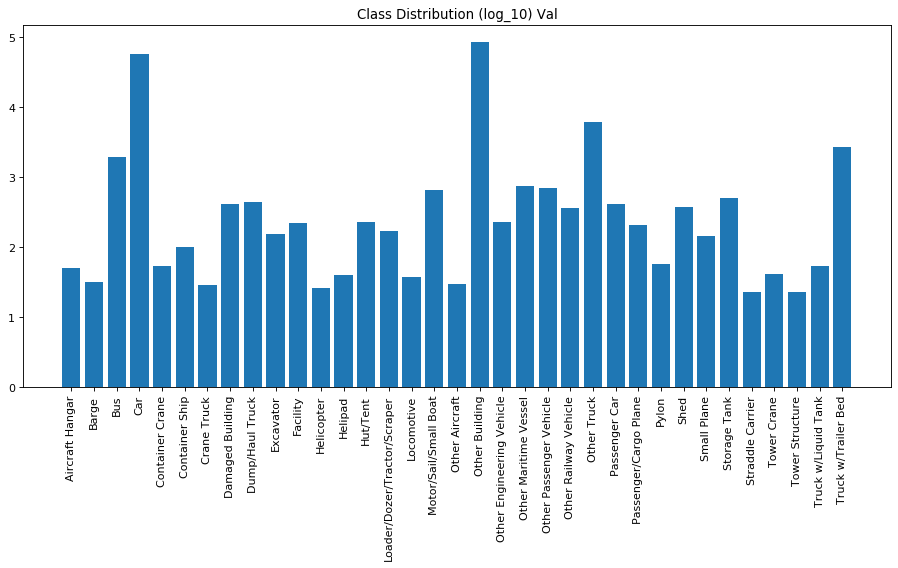

[('Aircraft Hangar', 51), ('Barge', 32), ('Bus', 1964), ('Car', 57656), ('Container Crane', 53), ('Container Ship', 101), ('Crane Truck', 29), ('Damaged Building', 409), ('Dump/Haul Truck', 439), ('Excavator', 153), ('Facility', 225), ('Helicopter', 26), ('Helipad', 40), ('Hut/Tent', 226), ('Loader/Dozer/Tractor/Scraper', 170), ('Locomotive', 37), ('Motor/Sail/Small Boat', 650), ('Other Aircraft', 30), ('Other Building', 85769), ('Other Engineering Vehicle', 229), ('Other Maritime Vessel', 742), ('Other Passenger Vehicle', 702), ('Other Railway Vehicle', 361), ('Other Truck', 6089), ('Passenger Car', 420), ('Passenger/Cargo Plane', 206), ('Pylon', 57), ('Shed', 376), ('Small Plane', 145), ('Storage Tank', 502), ('Straddle Carrier', 23), ('Tower Crane', 41), ('Tower Structure', 23), ('Truck w/Liquid Tank', 53), ('Truck w/Trailer Bed', 2669)]


In [73]:
sort=False
# top20seeds (xview_coco_v0.json) = [9653, 600, 3053, 7034, 6991, 6315, 1673, 1688, 5266, 3612, 157, 3073, 8910, 2793, 7289, 9655, 2806, 7523, 7433, 4673]
# Good seeds: (xview_coco_v0.json) [1688, 6315, 600, 3053]
# top20 (xview_coco_v1, 70/30 split): [55928, 65805, 73852, 90134, 62986, 32887, 56386, 18469, 6020, 41365, 23211, 17663, 26041, 71357, 49669, 97161, 63076, 6881, 26108, 16446]
# train_img_ids, val_img_ids = train_test_split(coco.img_ids, test_size=test_size, random_state=9653)
train_img_ids, val_img_ids = split(coco.img_ids, test_size=test_size, random_state=341589)
cat_counts, cat_percents = coco.get_class_dist()
plot_class_dist(cat_counts, "Original Data", sort=sort, log_only=True)
train_counts, train_percents = coco.get_class_dist(train_img_ids)
plot_class_dist(train_counts, "Train", sort=sort, log_only=True)
val_counts, val_percents = coco.get_class_dist(val_img_ids)
plot_class_dist(val_counts, "Val", sort=sort, log_only=True)

In [74]:
print(np.linalg.norm(val_percents-cat_percents, ord=np.inf))
print(np.sum(val_percents), np.sum(train_percents))
train_diff = train_percents-cat_percents
val_diff = val_percents-cat_percents
diff = np.abs(train_percents-val_percents)
for i,cats in enumerate(sorted(coco.cats, key=lambda c:np.max(np.maximum(train_diff, val_diff)))):
    print(
        F"{cats['name']}: %orig:{cat_percents[i]:.6f}, %tr:{train_percents[i]:.6f}, %val:{val_percents[i]:.6f}" + 
        F", trdif:{np.abs(train_diff[i]):.6f}, valdif:{np.abs(val_diff[i]):.6f}, d:{diff[i]:.5f}"
    )

0.001366240848475364
1.0 1.0
Other Aircraft: %orig:0.000322, %tr:0.000324, %val:0.000317, trdif:0.000002, valdif:0.000005, d:0.00001
Small Plane: %orig:0.000305, %tr:0.000345, %val:0.000199, trdif:0.000040, valdif:0.000106, d:0.00015
Passenger/Cargo Plane: %orig:0.011797, %tr:0.011636, %val:0.012222, trdif:0.000160, valdif:0.000425, d:0.00059
Helicopter: %orig:0.360008, %tr:0.360469, %val:0.358785, trdif:0.000461, valdif:0.001223, d:0.00168
Other Passenger Vehicle: %orig:0.000298, %tr:0.000286, %val:0.000330, trdif:0.000012, valdif:0.000032, d:0.00004
Car: %orig:0.000499, %tr:0.000451, %val:0.000629, trdif:0.000049, valdif:0.000129, d:0.00018
Bus: %orig:0.000296, %tr:0.000340, %val:0.000180, trdif:0.000044, valdif:0.000116, d:0.00016
Other Truck: %orig:0.001811, %tr:0.001535, %val:0.002545, trdif:0.000277, valdif:0.000734, d:0.00101
Truck w/Trailer Bed: %orig:0.002868, %tr:0.002919, %val:0.002732, trdif:0.000051, valdif:0.000136, d:0.00019
Truck w/Liquid Tank: %orig:0.001428, %tr:0.001

In [75]:
# Absolute class counts for original data, and train/val splits, sorted val split counts:
for i,catinfo in enumerate(sorted(coco.cats, key=lambda c: val_counts[c["name"]])):
    cat = catinfo["name"]
    print(F"{cat}: orig:{cat_counts[cat]}, train:{train_counts[cat]}, val:{val_counts[cat]}")

Straddle Carrier: orig:62, train:39, val:23
Tower Structure: orig:85, train:62, val:23
Helicopter: orig:68, train:42, val:26
Crane Truck: orig:174, train:145, val:29
Other Aircraft: orig:74, train:44, val:30
Barge: orig:179, train:147, val:32
Locomotive: orig:122, train:85, val:37
Helipad: orig:121, train:81, val:40
Tower Crane: orig:151, train:110, val:41
Aircraft Hangar: orig:189, train:138, val:51
Truck w/Liquid Tank: orig:148, train:95, val:53
Container Crane: orig:175, train:122, val:53
Pylon: orig:364, train:307, val:57
Container Ship: orig:293, train:192, val:101
Small Plane: orig:362, train:217, val:145
Excavator: orig:838, train:685, val:153
Loader/Dozer/Tractor/Scraper: orig:706, train:536, val:170
Passenger/Cargo Plane: orig:668, train:462, val:206
Facility: orig:883, train:658, val:225
Hut/Tent: orig:708, train:482, val:226
Other Engineering Vehicle: orig:968, train:739, val:229
Other Railway Vehicle: orig:2096, train:1735, val:361
Shed: orig:1185, train:809, val:376
Damage